<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_9_Light_v2_%D0%90%D0%B2%D1%82%D0%BE%D0%BA%D0%BE%D0%B4%D0%B8%D1%80%D0%BE%D0%B2%D1%89%D0%B8%D0%BA%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Light задание. Вариант 2
Используйте готовый ноутбук с занятия

In [ ]:
from tensorflow.keras.models import Model, Sequential # загружаем абстрактный класс базовой модели сети от кераса и последовательную модель
# Из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, Conv2DTranspose, concatenate
from tensorflow.keras.layers import  UpSampling2D, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K # подтягиваем базовые керасовские функции
from tensorflow.keras.optimizers import Adam, RMSprop # загружаем выбранный оптимизатор
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from tensorflow.keras import utils # загружаем утилиты кераса
from keras.utils import plot_model

from tensorflow.keras.datasets import mnist, fashion_mnist # загружаем готовые базы mnist
from tensorflow.keras.preprocessing import image # модуль для отрисовки изображения

import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций

import numpy as np # библиотека для работы с массивами данных
import pandas as pd # библиотека для анализа и обработки данных
from PIL import Image # модуль для отрисовки изображения
from sklearn.model_selection import train_test_split # модуль для разбивки выборки на тренировочную/тестовую
from sklearn.preprocessing import StandardScaler # модуль для стандартизации данных

from google.colab import drive #модуль для работы с google диском 
import os
import time

In [ ]:
os.chdir('/content/drive/My Drive/Занятие_9_Автокодировщики/data')

## 3 автокодировщика для подавления шума
Сравните их между собой и с исходным шумоподавляющим атокодировщиком. 

Сравнивайте по квадрату разности исходной картинки с востановленной из шума.

### Функции графики и ошибок

In [ ]:
def plotImages(xTrain, noisedXTrainFase, pred, shape=(112, 80)): # создадим функцию для вывода изображений как картинок
  n = 5  # количество картинок, которые хотим показать
  plt.figure(figsize=(12, 8)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(3, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем зашумленные картинки
      ax = plt.subplot(3, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(noisedXTrainFase[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(3, n, i + 6 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

  plt.show()

In [ ]:
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

In [ ]:
# Зададим пару массивов и проверим работу функции
x1 = np.array([1, 1, 1]) # создаем первый массив
x2 = np.array([0, 0, 0]) # создаем второй массив
print(getMSE(x1,x2)) # выведем ошибку полученную нашей функцией

1.0


### Шумоподавляющие автокодировщики

In [ ]:
def baseAutoencoder(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных

    z = MaxPooling2D()(x) # передаём на слой подвыборки

    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=Adam(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

In [ ]:
#https://www.pvsm.ru/python/333491, но доработанная мной
def baseAutoencoder2(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры
    k=32

    x = Conv2D(4*k, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 

    x = Conv2D(8*k, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(8*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(16*k, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(16*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(32*k, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(32*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(64*k, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(32*k, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(16*k, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16*k, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8*k, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    x = Conv2D(2*k, (3, 3),  padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
    
    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001), loss='mse')

    return model # функция вернёт заданную модель

In [ ]:
# вариант с урока, но увеличил число нейронов на k
def baseAutoencoder3(shape=(112,80,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры
    k=4

    x = Conv2D(32, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных
    x = MaxPooling2D()(x) # передаём на слой подвыборки, снижающий размерность поступивших на него данных

    x = Conv2D(64*k, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # пропускаем через слой нормализации данных 
    x = Conv2D(64*k*2, (3, 3), padding='same', activation='relu')(x)  # далее снова слой двумерной свёртки
    x = BatchNormalization()(x) # и еще слой нормализации данных

    z = MaxPooling2D()(x) # передаём на слой подвыборки

    x = Conv2DTranspose(64*k*2, (2, 2), strides=(2, 2), padding='same', activation='relu')(z) # слой разжимает данные(с 28*20 на 56*40)
    x = BatchNormalization()(x) # слой нормализации данных
    
    x = Conv2D(64*k, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    # Сжатие MaxPooling2D не применяем

    x = Conv2DTranspose(32*k, (2, 2), strides=(2, 2), padding='same', activation='relu')(x) # слой разжимает данные(с 56*40 на 112*80)
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x) # ещё слой двумерной свёртки
    x = BatchNormalization()(x) # слой нормализации данных

    # Финальный слой двумерной свертки, выдающий итоговое изображение
    x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    model = Model(img_input, x) # указываем модель, с оригинальным изображением на входе в сеть и сжатым-разжатым на выходе из сети
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss='mean_squared_error') # компилируем модель с оптимайзером Адам и среднеквадратичной ошибкой

    return model # функция вернёт заданную модель

### Загрузка базы

In [ ]:
!unzip -q '/content/drive/My Drive/Занятие_9_Автокодировщики/data/Лица.zip' # распоковываем базу с лицами с google диска в colaboratory

In [ ]:
images_dir = 'Лица' # зададим имя папки в которую распоковали изображения
img_height = 112 # зададим высоту изображений
img_width = 80 # зададим ширину избражений

In [ ]:
# функция загрузки изображений, на вход принемает имя папки с изображениями, высоту и ширину к которой будут преобразованы загружаемые изображения
def load_images(images_dir, img_height, img_width): 
  list_images = [] # создаем пустой список в который будем загружать изображения
  for img in os.listdir(images_dir): # получим список изображений и для каждого изображения
  # добавим в список изображение в виде массива, с заданными размерами, в отенках серого
    list_images.append(image.img_to_array(image.load_img(os.path.join(images_dir, img), target_size=(img_height, img_width), color_mode='grayscale')))
  return np.array(list_images) # возвращаем numpy массив загруженных избражений

In [ ]:
cur_time = time.time() 
xTrain_imag = load_images(images_dir, img_height, img_width) # загрузим избражения лиц
print ('Время загрузки: ', round(time.time()-cur_time, 2), 'с', sep='')

Время загрузки: 32.2с


In [ ]:
xTrain_img = xTrain_imag/255 # отнормируем изображения от 0 до 1
xTrain_img.shape # выведем размерность массива

(5018, 112, 80, 1)

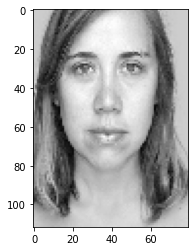

In [ ]:
plt.imshow(xTrain_img[np.random.randint(5, xTrain_img.shape[0])].reshape(112,80), cmap='gray') #выведем случайное изображение
plt.show()

### Добавим шум

In [ ]:
def addNoise(x, noiseVal): # объявим функцию добавления шума
  #noise = np.random.sample((x.shape[0],28,28,1))
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

noisedXTrainFase = addNoise(xTrain_img, 0.4) # cоздаем зашумленный вариант лиц из xTrain_img
noisedXTrainFase.shape # выведем размерность массива

(5018, 112, 80, 1)

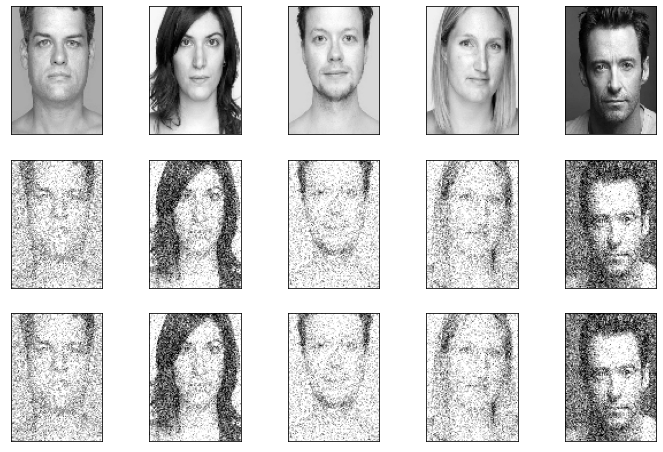

In [ ]:
plotImages(xTrain_img, noisedXTrainFase, noisedXTrainFase) # выведем на экран исходные лица и зашумленные варианты 

### Тренируем Модель 1: модель из урока с исправленными xTest

In [ ]:
# модель из урока
modelAutoFase = baseAutoencoder() # создаем автокодировщик
# грузим данные в нашу модель, берём первые 4700 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img
modelAutoFase.fit(noisedXTrainFase[:4700], xTrain_img[:4700], epochs=150, batch_size=100,
                  verbose = 1,
                  validation_data = (noisedXTrainFase[4700:], xTrain_img[4700:]))

Epoch 1/150
47/47 [==============================] - 3s 62ms/step - loss: 0.0477 - val_loss: 0.0641
Epoch 2/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0134 - val_loss: 0.0648
Epoch 3/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0088 - val_loss: 0.0655
Epoch 4/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0074 - val_loss: 0.0639
Epoch 5/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0066 - val_loss: 0.0589
Epoch 6/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0061 - val_loss: 0.0478
Epoch 7/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0059 - val_loss: 0.0371
Epoch 8/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0056 - val_loss: 0.0240
Epoch 9/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0054 - val_loss: 0.0163
Epoch 10/150
47/47 [==============================] - 3s 56ms/step - loss: 0.0053 - val_loss: 0.0112

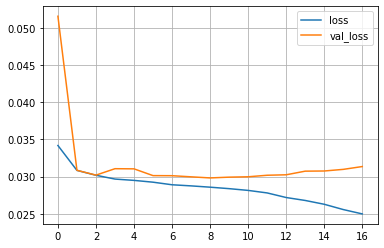

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.grid()
plt.show()

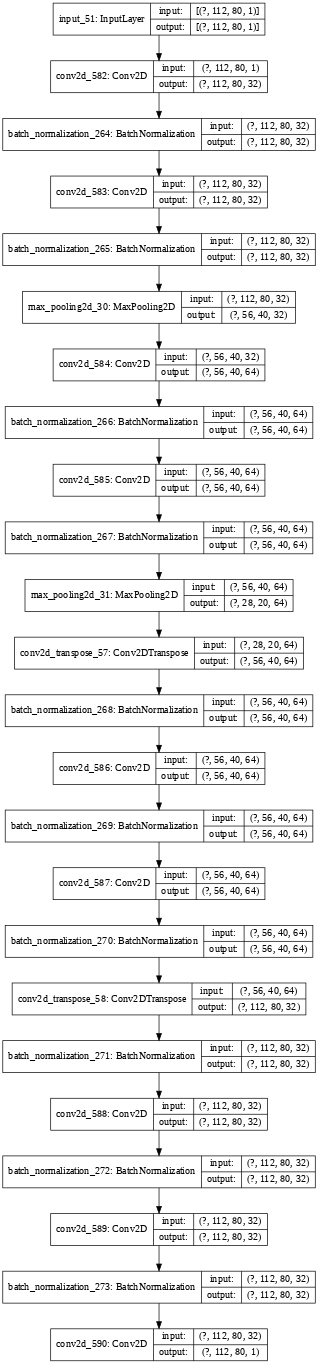

In [ ]:
plot_model(modelAutoFase, dpi=50, show_shapes=True, show_layer_names=True)

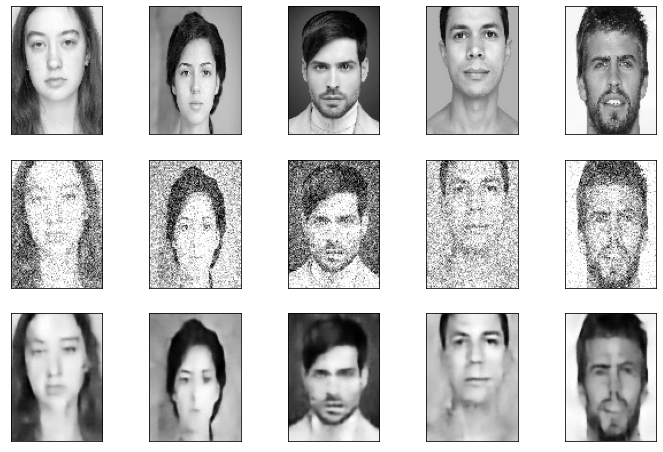

In [ ]:
predFase = modelAutoFase.predict(noisedXTrainFase[:100]) # сделаем предикт для первых ста картинок лиц
predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип

plotImages(xTrain_img, noisedXTrainFase, predFase) #выведем оригинальные, зашумленные и сгенерированные автокодировщиком

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFase = [getMSE(xTrain_img[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
#print("Ошибка на Лицах:", errFase[80:]) #посмотрим последнии 20
print("Средняя ошибка на Лицах:", round(sum(errFase[80:]) / len(errFase[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Лицах:", round(min(errFase),4)) #найдем минимальную ошибку

Средняя ошибка на Лицах: 0.0032
Минимальная ошибка на Лицах: 0.0018


In [ ]:
bias = 0.005 # установим какое-то пороговое значение
isFase = [e < bias for e in errFase[80:]] # запишем каждую ошибку больше порогового значения
print("Лица распознаны, как Лица: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

Лица распознаны, как Лица: 95.0%


### Тренируем Модель 2: своя модель

In [ ]:
modelAutoFase2 = baseAutoencoder2() # создаем автокодировщик
# грузим данные в нашу модель, берём первые 4700 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-06, verbose = 1)

history = modelAutoFase2.fit(noisedXTrainFase[:4700], xTrain_img[:4700], epochs=60, 
                  validation_data = (noisedXTrainFase[4700:], xTrain_img[4700:]),
                  verbose = 1, batch_size=10,
                  callbacks = [early_stopping, reduce_lr])

Epoch 1/60
470/470 [==============================] - 45s 96ms/step - loss: 0.0097 - val_loss: 0.0272
Epoch 2/60
470/470 [==============================] - 45s 95ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 3/60
470/470 [==============================] - 45s 95ms/step - loss: 0.0045 - val_loss: 0.0038
Epoch 4/60
470/470 [==============================] - 45s 95ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 5/60
470/470 [==============================] - 45s 95ms/step - loss: 0.0038 - val_loss: 0.0038
Epoch 6/60
470/470 [==============================] - ETA: 0s - loss: 0.0036
Epoch 00006: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
470/470 [==============================] - 45s 95ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 7/60
470/470 [==============================] - 45s 95ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 8/60
470/470 [==============================] - 45s 95ms/step - loss: 0.0033 - val_loss: 0.0051
Epoch 9/60
470/470 [==================

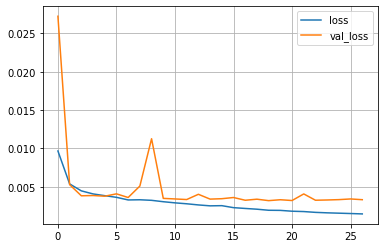

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.grid()
plt.show()

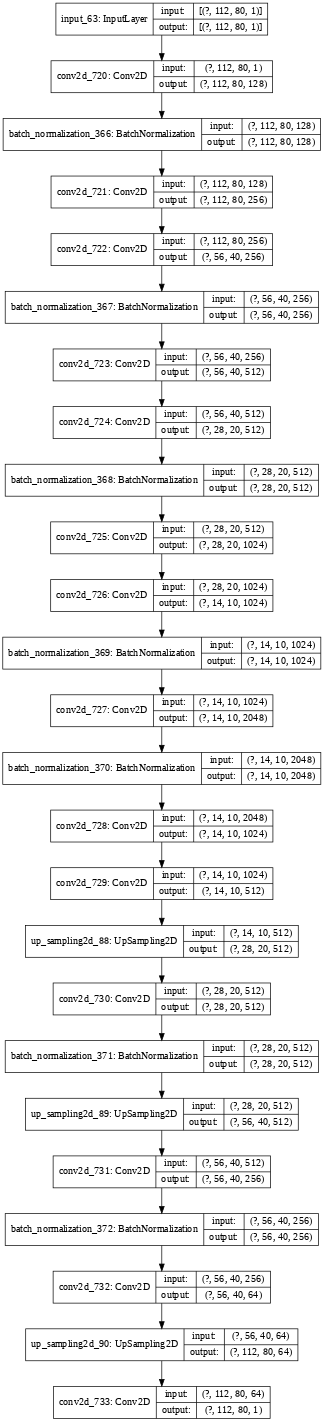

In [ ]:
plot_model(modelAutoFase2, dpi=50, show_shapes=True, show_layer_names=True)

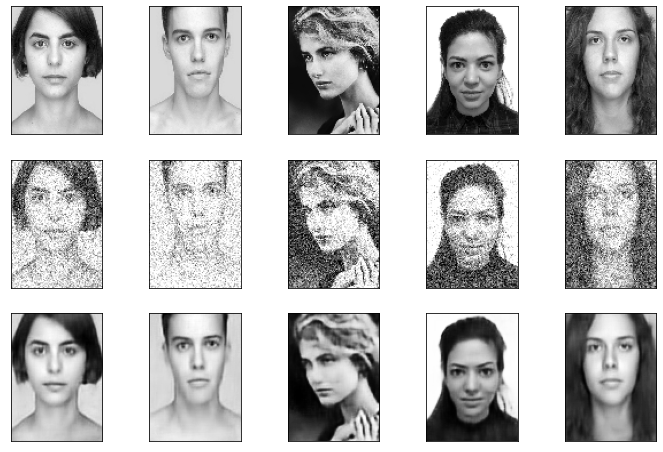

In [ ]:
predFase = modelAutoFase2.predict(noisedXTrainFase[:100]) # сделаем предикт для первых ста картинок лиц
predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип

plotImages(xTrain_img, noisedXTrainFase, predFase) #выведем оригинальные, зашумленные и сгенерированные автокодировщиком

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFase = [getMSE(xTrain_img[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
#print("Ошибка на Лицах:", errFase[80:]) #посмотрим последнии 20
print("Средняя ошибка на Лицах:", round(sum(errFase[80:]) / len(errFase[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Лицах:", round(min(errFase),4)) #найдем минимальную ошибку

Средняя ошибка на Лицах: 0.0017
Минимальная ошибка на Лицах: 0.0007


In [ ]:
bias = 0.005 # установим какое-то пороговое значение
isFase = [e < bias for e in errFase[80:]] # запишем каждую ошибку больше порогового значения
print("Лица распознаны, как Лица: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

Лица распознаны, как Лица: 95.0%


### Тренируем Модель 3: модель с урока с измененнным числом нейроном и уменьшенным батчем

In [ ]:
modelAutoFase3 = baseAutoencoder3() # создаем автокодировщик
# грузим данные в нашу модель, берём первые 4700 из xTrain_img и на вход, и на выход, в качестве проверочной берем оставшиеся из xTrain_img

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=1e-06, verbose = 1)

history = modelAutoFase3.fit(noisedXTrainFase[:4700], xTrain_img[:4700], epochs=60, 
                  validation_data = (noisedXTrainFase[4700:], xTrain_img[4700:]),
                  verbose = 1, batch_size=20,
                  callbacks = [reduce_lr, early_stopping])

Epoch 1/60
235/235 [==============================] - 13s 54ms/step - loss: 0.0087 - val_loss: 0.0637
Epoch 2/60
235/235 [==============================] - 12s 53ms/step - loss: 0.0051 - val_loss: 0.0173
Epoch 3/60
235/235 [==============================] - 12s 53ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 4/60
235/235 [==============================] - 12s 53ms/step - loss: 0.0045 - val_loss: 0.0035
Epoch 5/60
235/235 [==============================] - 12s 53ms/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6/60
235/235 [==============================] - 12s 53ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 7/60
235/235 [==============================] - ETA: 0s - loss: 0.0042
Epoch 00007: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
235/235 [==============================] - 12s 53ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 8/60
235/235 [==============================] - 12s 53ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 9/60
235/235 [==================

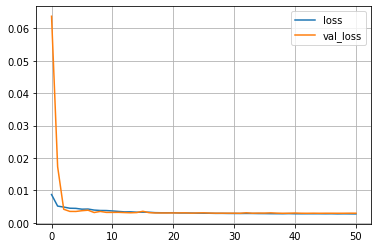

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.grid()
plt.show()

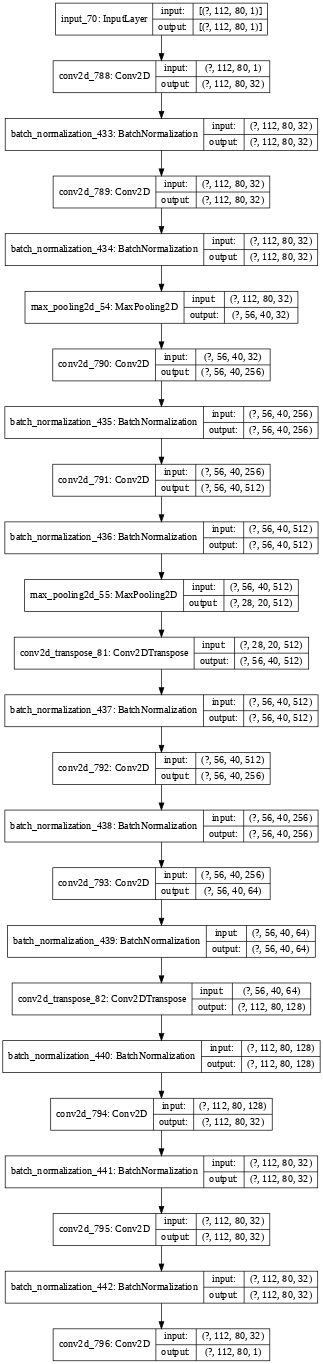

In [ ]:
plot_model(modelAutoFase3, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#modelAutoFase.save_weights('modelAutoFase.h5') # Сохраняем модель
#modelAutoFase.load_weights('modelAutoFase.h5') # Сохраняем модель

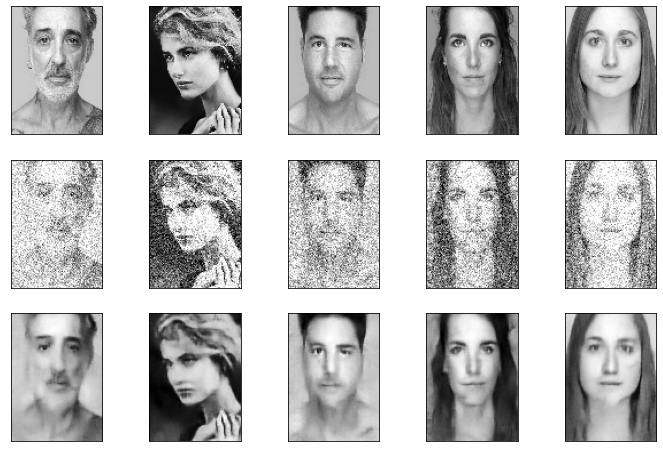

In [ ]:
predFase = modelAutoFase3.predict(noisedXTrainFase[:100]) # сделаем предикт для первых ста картинок лиц
predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип

plotImages(xTrain_img, noisedXTrainFase, predFase) #выведем оригинальные, зашумленные и сгенерированные автокодировщиком

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFase = [getMSE(xTrain_img[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
#print("Ошибка на Лицах:", errFase[80:]) #посмотрим последнии 20
print("Средняя ошибка на Лицах:", round(sum(errFase[80:]) / len(errFase[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Лицах:", round(min(errFase),4)) #найдем минимальную ошибку

Средняя ошибка на Лицах: 0.0026
Минимальная ошибка на Лицах: 0.0015


In [ ]:
bias = 0.005 # установим какое-то пороговое значение
isFase = [e < bias for e in errFase[80:]] # запишем каждую ошибку больше порогового значения
print("Лица распознаны, как Лица: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

Лица распознаны, как Лица: 95.0%


## Обучение автокодировщика на базе Fashion Mnist

Проверьте, как он преобразует картинки одежды, на которых не обучался.

In [ ]:
from tensorflow.keras.datasets import fashion_mnist # загружаем готовую базу Fashion Mnist

In [ ]:
# загружаем данные из базы с разбивкой на train/test
(xTrain_fMnist, yTrain_fMnist), (xTest_fMnist, yTest_fMnist) = fashion_mnist.load_data() 
xTrain_fMnist = xTrain_fMnist.astype('float32')/255 # представляем в виде значений от 0 до 1
# меняем форму, приводим к нужным нам размерам
xTrain_fMnist = xTrain_fMnist.reshape(xTrain_fMnist.shape[0], 28, 28, 1) 

In [ ]:
# Добавляем шум

def addNoise(x, noiseVal): # объявим функцию добавления шума
  #noise = np.random.sample((x.shape[0],28,28,1))
  noise = np.random.normal(loc=0.5, scale=0.5, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

noisedXTrainFase = addNoise(xTrain_fMnist, 0.4) # cоздаем зашумленный вариант лиц из xTrain_fMnist

noisedXTrainFase.shape # выведем размерность массивов Train

(60000, 28, 28, 1)

In [ ]:
# Функциz графики
def plotImages_fMnist(xTrain, noisedXTrainFase, pred, shape=(28, 28)): # создадим функцию для вывода изображений как картинок
  n = 7  # количество картинок, которые хотим показать
  plt.figure(figsize=(16, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(3, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index].reshape(shape)) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем зашумленные картинки
      ax = plt.subplot(3, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(noisedXTrainFase[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(3, n, i + 8 + n) # выведем область рисования Axes 
      plt.imshow(pred[index].reshape(shape)) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

  plt.show()

In [ ]:
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

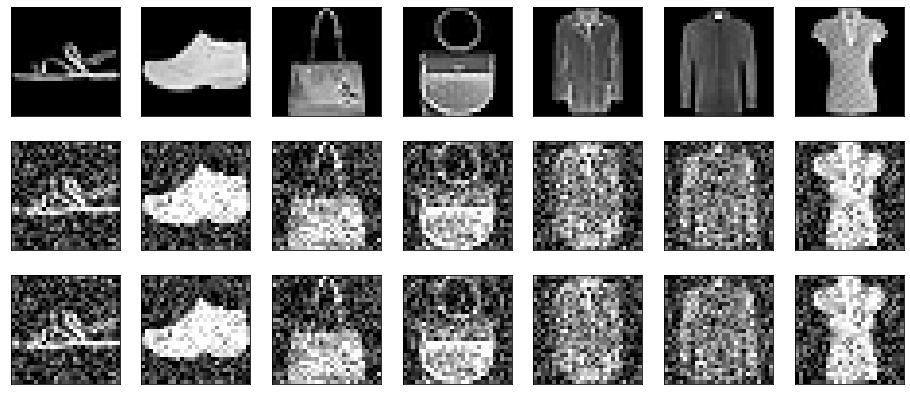

In [ ]:
# выведем на экран исходные и зашумленные варианты 
plotImages_fMnist(xTrain_fMnist, noisedXTrainFase, noisedXTrainFase) 

In [ ]:
#https://www.pvsm.ru/python/333491, но доработанная мной
def baseAutoencoder_fM(shape=(28,28,1)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры
    k=28

    x = Conv2D(4*k, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 

    x = Conv2D(7*k, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(7*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    #x = BatchNormalization()(x)

    #x = Conv2D(28*k, (3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(28*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    #x = BatchNormalization()(x)

    x = Conv2D(28*k, (3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu')(x)

    #x = UpSampling2D((2, 2))(x)
    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu')(x)
    #x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(7*k, (3, 3), padding='same', activation='relu')(x)
    #x = BatchNormalization()(x)

    x = Conv2D(2*k, (3, 3),  padding='same', activation='relu')(x)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)
    
    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001), loss='mse')

    return model # функция вернёт заданную модель

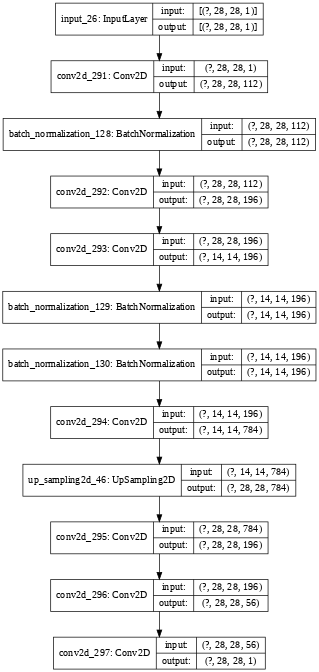

In [ ]:
model_fM = baseAutoencoder_fM() # создаем автокодировщик
plot_model(model_fM, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=2, min_lr=1e-06, verbose = 1)

history = model_fM.fit(noisedXTrainFase[:50000], xTrain_fMnist[:50000], epochs=20, 
                  validation_data = (noisedXTrainFase[50000:], xTrain_fMnist[50000:]),
                  verbose = 1,
                  #batch_size=20,
                  callbacks = [early_stopping, reduce_lr])

Epoch 1/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0063 - val_loss: 0.0051
Epoch 2/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 3/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 4/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 5/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0043 - val_loss: 0.0045
Epoch 6/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 7/20
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0041 - val_loss: 0.0043
Epoch 8/20
1561/1563 [============================>.] - ETA: 0s - loss: 0.0041
Epoch 00008: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
1563/1563 [==============================] - 31s 20ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 9/20
1563/1563

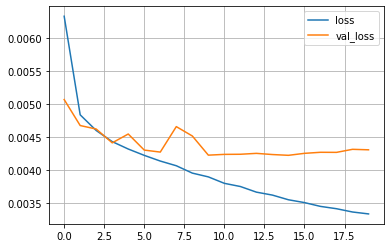

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.grid()
plt.show()

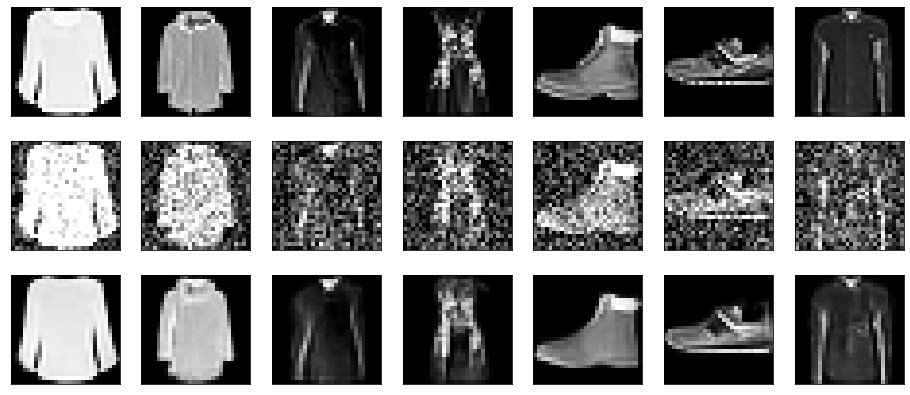

In [ ]:
predFase = model_fM.predict(noisedXTrainFase[50000:]) # сделаем предикт для 21 изображения
predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип

#выведем оригинальные, зашумленные и сгенерированные автокодировщиком
plotImages_fMnist(xTrain_fMnist, noisedXTrainFase, predFase)  

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для лиц 
errFase = [getMSE(xTrain_fMnist[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
#print("Ошибка на Лицах:", errFase[80:]) #посмотрим последнии 20
print("Средняя ошибка на Fashion Mnist:", round(sum(errFase[80:]) / len(errFase[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Fashion Mnist:", round(min(errFase),4)) #найдем минимальную ошибку

bias = 0.005 # установим какое-то пороговое значение
isFase = [e < bias for e in errFase[80:]] # запишем каждую ошибку больше порогового значения
print("Обьекты распознаны, как Fashion Mnist: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

Средняя ошибка на Fashion Mnist: 0.0034
Минимальная ошибка на Fashion Mnist: 0.0006
Обьекты распознаны, как Fashion Mnist: 87.0%


## Обучение автокодировщика на базе CIFAR-10

Проверьте, как он преобразует картинки одежды, на которых не обучался.

In [ ]:
from tensorflow.keras.datasets import cifar10 # загружаем готовую базу cifar10

In [ ]:
# загружаем данные из базы с разбивкой на train/test
(xTrain_cifar10, yTrain_cifar10), (xTest_cifar10, yTest_cifar10) = cifar10.load_data() 
xTrain_cifar10 = xTrain_cifar10.astype('float32')/255 # представляем в виде значений от 0 до 1
# меняем форму, приводим к нужным нам размерам
xTrain_cifar10 = xTrain_cifar10.reshape(xTrain_cifar10.shape[0], 32, 32, 3) 

In [ ]:
# Добавляем шум

def addNoise(x, noiseVal): # объявим функцию добавления шума
  noise = np.random.normal(loc=0.5, scale=0.25, size=x.shape) # создаем шум(с центром в 0.5 и отклонением 0.5)
  
  # Cкладываем с произведением шума*на усилитель шума и вводим ограничение значений от 0 до 1(clip)
  return np.clip(x + noiseVal * noise, 0., 1.) 

noisedXTrainFase = addNoise(xTrain_cifar10, 0.4) # cоздаем зашумленный вариант лиц из xTrain_fMnist

noisedXTrainFase.shape # выведем размерность массивов Train

(50000, 32, 32, 3)

In [ ]:
# Функциz графики
def plotImages_cifar10(xTrain, noisedXTrainFase, pred, shape=(32, 32)): # создадим функцию для вывода изображений как картинок
  n = 7  # количество картинок, которые хотим показать
  plt.figure(figsize=(16, 7)) # указываем размеры фигуры
  for i in range(n): # для каждой картинки из n(5)
      index = np.random.randint(0, pred.shape[0]) # startIndex - начиная с какого индекса хотим заплотить картинки
      # Показываем картинки из тестового набора
      ax = plt.subplot(3, n, i + 1) # выведем область рисования Axes
      plt.imshow(xTrain[index]) # отрисуем правильные картинки в размере 112*80      
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем зашумленные картинки
      ax = plt.subplot(3, n, i + 1 + n) # выведем область рисования Axes 
      plt.imshow(noisedXTrainFase[index]) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

      # Показываем восстановленные картинки
      ax = plt.subplot(3, n, i + 8 + n) # выведем область рисования Axes 
      plt.imshow(pred[index]) # отрисуем обработанные сеткой картинки в размере 112*80     
      plt.gray() # выведем в черно-белом цвете
      ax.get_xaxis().set_visible(False) # скрываем вывод координатной оси x
      ax.get_yaxis().set_visible(False) # скрываем вывод координатной оси y

  plt.show()

In [ ]:
def getMSE(x1, x2): # создадим функцию среднеквадратичной ошибки
  x1 = x1.flatten() # сплющиваем в одномерный вектор
  x2 = x2.flatten() # сплющиваем в одномерный вектор
  delta = x1 - x2 # находим разницу
  return sum(delta ** 2) / len(delta) # и возвращаем сумму квадратов разницы, делённую на длину разницы

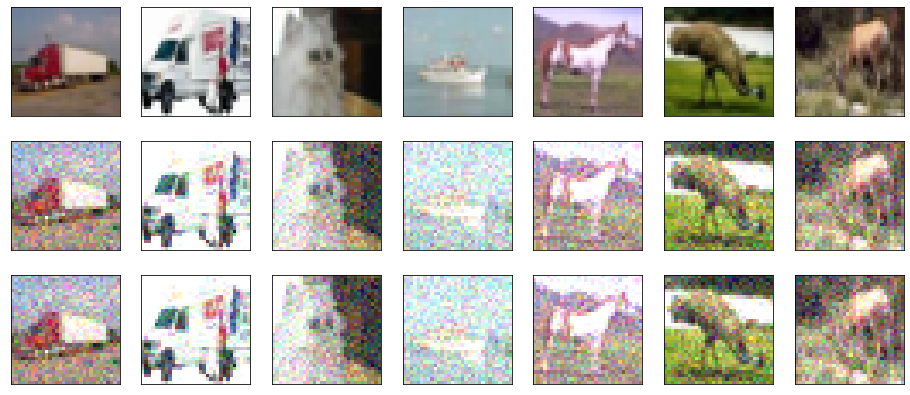

In [ ]:
# выведем на экран исходные и зашумленные варианты 
plotImages_cifar10(xTrain_cifar10, noisedXTrainFase, noisedXTrainFase) 

In [ ]:
#https://www.pvsm.ru/python/333491, но доработанная мной
def baseAutoencoder_c10(shape=(32,32,3)): # зададим функцию создания базового автокодировщика
    img_input = Input((shape)) # задаём входные размеры
    k=32

    x = Conv2D(4*k, (3, 3), padding='same', activation='relu')(img_input) # входные данные передаем на слой двумерной свёртки
    x = BatchNormalization()(x) # затем пропускаем через слой нормализации данных 

    x = Conv2D(7*k, (3, 3), padding='same', activation='relu')(x)
    x = Conv2D(7*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    x = BatchNormalization()(x)

    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    #x = BatchNormalization()(x)

    #x = Conv2D(28*k, (3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(28*k, (3, 3), padding='same', activation='relu', strides=2)(x)
    #x = BatchNormalization()(x)

    x = Conv2D(28*k, (3, 3), padding='same', activation='relu')(x)
    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu')(x)

    #x = UpSampling2D((2, 2))(x)
    #x = Conv2D(14*k, (3, 3), padding='same', activation='relu')(x)
    #x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)
    x = Conv2D(7*k, (3, 3), padding='same', activation='relu')(x)
    #x = BatchNormalization()(x)

    x = Conv2D(2*k, (3, 3),  padding='same', activation='relu')(x)
    #x = UpSampling2D((2, 2))(x)
    x = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)
    
    model = Model(img_input, x)
    model.compile(optimizer=Adam(lr=0.0001), loss='mse')

    return model # функция вернёт заданную модель

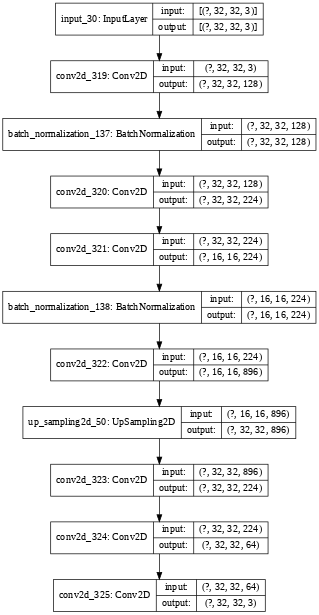

In [ ]:
model_c10 = baseAutoencoder_c10() # создаем автокодировщик
plot_model(model_c10, dpi=50, show_shapes=True, show_layer_names=True)

In [ ]:
#Коллбэки
early_stopping = EarlyStopping(monitor = 'loss', patience = 5, verbose = 0, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.8, patience=2, min_lr=1e-06, verbose = 1)

history = model_c10.fit(noisedXTrainFase[:50000], xTrain_cifar10[:50000], epochs=15, 
                  validation_data = (noisedXTrainFase[50000:], xTrain_cifar10[50000:]),
                  verbose = 1,
                  #batch_size=20,
                  callbacks = [early_stopping, reduce_lr])

Epoch 1/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0033
Epoch 2/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0022
Epoch 3/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0020
Epoch 4/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0018
Epoch 5/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0017
Epoch 6/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0017
Epoch 7/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0016
Epoch 8/15
1562/1563 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00008: ReduceLROnPlateau reducing learning rate to 7.999999797903001e-05.
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0016
Epoch 9/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0016
Epoch 10/15
1563/1563 [==============================] - 38s 24ms/step - loss: 0.0015
E

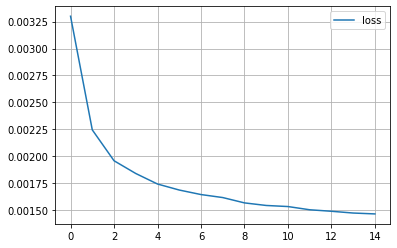

In [ ]:
#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["loss"], label='loss')
#plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.grid()
plt.show()

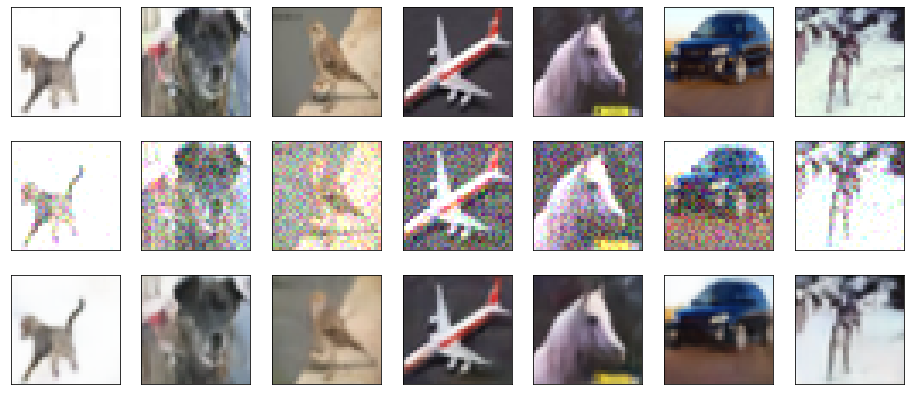

In [ ]:
predFase = model_c10.predict(noisedXTrainFase[:50000]) # сделаем предикт для 21 изображения
predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип

#выведем оригинальные, зашумленные и сгенерированные автокодировщиком
plotImages_fMnist(xTrain_cifar10, noisedXTrainFase, predFase)  

In [ ]:
# Возьмем среднеквадратичные ошибки и выведем их для изображений
errFase = [getMSE(xTrain_cifar10[i], predFase[i] / 255) for i in range(len(predFase))] # посчитаем ошибку для всех изображений
#print("Ошибка на Лицах:", errFase[80:]) #посмотрим последнии 20
print("Средняя ошибка на Fashion Mnist:", round(sum(errFase[80:]) / len(errFase[80:]), 4)) # посчитаем для последних 20 среднюю ошибку
print("Минимальная ошибка на Fashion Mnist:", round(min(errFase),4)) #найдем минимальную ошибку

bias = 0.005 # установим какое-то пороговое значение
isFase = [e < bias for e in errFase[80:]] # запишем каждую ошибку больше порогового значения
print("Обьекты распознаны, как Fashion Mnist: ", round(100*sum(isFase) / len(isFase)),"%", sep="")

Средняя ошибка на Fashion Mnist: 0.0015
Минимальная ошибка на Fashion Mnist: 0.0003
Обьекты распознаны, как Fashion Mnist: 100.0%


## Пробую наобученной сетке зашумлить и восстановить фотографию
-----
ну тут, похоже, проблема с размерностями
на этих фотографиях буду учить сеть раскрашивать в Ultra

<class 'PIL.Image.Image'>
img_array:  (512, 768, 3)
<class 'numpy.ndarray'>


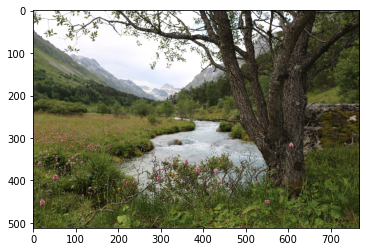

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
%matplotlib inline

img = image.load_img('/content/drive/My Drive/Занятие_9_Автокодировщики/data/1O9A2033.JPG', target_size=(512, 768))
print(type(img))
plt.imshow(img)

img_array = img_to_array(img) # перевели картинку в массив данных
print('img_array: ' , img_array.shape) # вывел размерность массива
print(type(img_array))

<class 'numpy.ndarray'> (512, 768, 3)


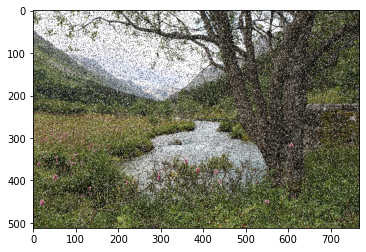

In [ ]:
# Добавляем шум
import random 
import cv2 

def sp_noise(image,prob):
    output = np.zeros(image.shape,np.uint8) 
    thres = 1 - prob 
    for i in range(image.shape[0]): 
     for j in range(image.shape[1]): 
      rdn = random.random() 
      if rdn < prob: output[i][j] = 0 
      elif rdn > thres: output[i][j] = 255 
      else: output[i][j] = image[i][j] 
    return output 

noisedImg = sp_noise(img_array, 0.1) 
print(type(noisedImg), noisedImg.shape) # выведем размерность
plt.imshow(noisedImg)

In [ ]:
xTrain_cifar10.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 512, 768, 3)
(512, 768, 3)


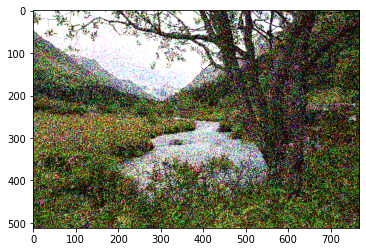

In [ ]:
# или так:
noise = (np.random.sample((1, 512, 768, 3)))*255//1 # создаем 1 картинку шума
print(noise.shape)

noisedImg = img_array - noise
print(noisedImg[0].shape)
plt.imshow(noisedImg[0])

TypeError: ignored

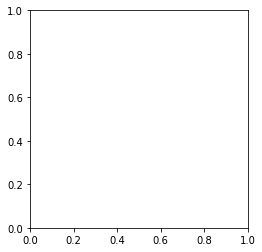

In [ ]:
# понял, что 

predFase = model_c10.predict(noisedImg) # сделаем предикт для изображения
predFase = predFase * 255 # представляем в виде значений от 0 до 255
predFase = predFase.astype('uint8') # устанавливаем 8битовый тип
plt.imshow(predFase)